In [ ]:
import seaborn as sns

try:
    import scrapy
except:
    !pip install scrapy
    import scrapy
from scrapy.crawler import CrawlerProcess

In [ ]:
# Settings for notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Classe bot para obter uma base de dados de preços de carnes dos mercados Super Nosso e Angeloni, 
# fazendo a leitura do Html e obtendo os dados conforme as classes de css ou TAGs específicas do Html
import json

class PriceMeatBot(scrapy.Spider):
    name = "Price Meat Bot"
    start_urls = ["https://www.supernossoemcasa.com.br/aves-carnes-e-peixes/carnes-bovinas",
                  "https://www.angeloni.com.br/super/c/carnes-aves-e-peixes/bovino/_/N-bnw3pj?No=96&Nr=AND(prop.product.indexableSuper%3A1%2CAND(product.store%3A14%2Cproduct.siteId%3Asuper%2Cprop.product.indexableSuper%3A1%2CNOT(dim.product.type%3Aproduct-recipe))%2Cproduct.store%3A14%2CNOT(dim.product.type%3Aproduct-recipe)%2Cproduct.siteId%3Asuper)&Nrpp=1000"]
            
    def parse(self, response):
        mercadoSuperNosso = False
        if 'supernossoemcasa' in response.request.url: 
            mercadoSuperNosso = True
        SELECTOR = ''
        if(mercadoSuperNosso):
            SELETOR = ".item-shelf"
        else: #Angeloni
            SELETOR = ".box-produto"
        carnes = []
        ret = response.css(SELETOR);
        for c in ret:
            carne = {}
            NOME_SELETOR = ""
            PRECO_SELECTOR = "" 
            CENTAVOS_SELECTOR = "" #Variavel só do Angeloni
            UN_SELECTOR = "" #Variavel só do Angeloni
            if(mercadoSuperNosso):
                NOME_SELETOR = ".product-name a::text"
                PRECO_SELECTOR = ".best-price ::text" 
            else: #Angeloni
                NOME_SELETOR = ".box-produto__desc-prod ::text"
                PRECO_SELECTOR = ".box-produto__preco__valor ::text"
                CENTAVOS_SELECTOR = ".box-produto__preco__centavos ::text"
                UN_SELECTOR = ".box-produto__preco__tipo ::text"
            
            if(mercadoSuperNosso):
                try:
                    carne['nome'] = c.css(NOME_SELETOR).extract_first().strip() 
                except:    
                    carne['nome'] = 'Erro ao Obter'
                try:
                    carne['preco'] = (c.css(PRECO_SELECTOR).extract_first().replace('R$','').strip()).replace(',','.')           
                except:    
                    carne['preco'] = '0.00'
                try:
                    textUn = c.css(NOME_SELETOR).extract_first().strip() 
                    un = 'none'
                    for t in textUn.split():            
                        if t.upper().endswith('G') & t[0:1].isdigit(): 
                            un = t
                        elif t.upper() == 'KG':
                            un = 'kg'                    
                    carne['un'] = un
                except:
                    carne['un'] = 'None'
                carne['Mercado'] = 'SuperNosso'    
            else: #Angeloni
                try:
                    carne['nome'] = c.css(NOME_SELETOR).extract_first()
                except:    
                    carne['nome'] = 'Erro ao Obter'
                try:
                    carne['preco'] = (c.css(PRECO_SELECTOR).extract_first() + c.css(CENTAVOS_SELECTOR).extract_first()).replace(',','.')            
                except:    
                    carne['preco'] = '0.00'
                try:    
                    carne['un'] = c.css(UN_SELECTOR).extract()[-1].replace('/','').strip()
                except:
                    carne['un'] = 'None'
                carne['Mercado'] = 'Angeloni'    
            
            carnes.append(carne)        
        
        with open('dataPriceMeatSuperNosso.json' if mercadoSuperNosso else 'dataPriceMeatAngeloni.json', 'w', encoding='utf-8') as f:
            json.dump(carnes, f, ensure_ascii=False, indent=4)
       



In [ ]:
import sys     
if "twisted.internet.reactor" in sys.modules: 
    del sys.modules["twisted.internet.reactor"]
    
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

## Aqui está executando a classe bot "PriceMeatBot" criada logo acima
process.crawl(PriceMeatBot)
process.start()

In [ ]:
import pandas as pd

dfSuperNosso = pd.read_json('dataPriceMeatSuperNosso.json')
dfAngeloni = pd.read_json('dataPriceMeatAngeloni.json')

dfMercado = dfSuperNosso.append(dfAngeloni)


dfMercado



,nome,preco,un,Mercado
0,Linguiça Angus Cara Preta Costela Congelada 300g,9.99,300g,SuperNosso
1,Carne Patinho Moído Super Nosso 500g,24.95,500g,SuperNosso
2,PATINHO BIFE ANGUS 400G,24.99,400G,SuperNosso
3,PATINHO ANGUS 400G MOIDO,32.99,400G,SuperNosso
4,Acem Porcionado Kg Resfd,32.99,kg,SuperNosso
...,...,...,...,...
158,Alcatra Bovina BEST BEEF Angus Resfriada kg,0.00,None,Angeloni
159,Alcatra Bovina BEST BEEF Angus Resfriada kg,0.00,None,Angeloni
160,Costela Bovina BEST BEEF Grelha Congelada kg,0.00,None,Angeloni
161,Maminha Bovina KORIN Orgânica Resfriada kg,0.00,None,Angeloni


In [ ]:
dfMercado.dtypes

nome        object
preco      float64
un          object
Mercado     object
dtype: object

In [ ]:
#Excluindo as carnes sem preço
dfMercado.drop(dfMercado[dfMercado.preco == 0.00].index, inplace=True)

In [ ]:
dfMercado

,nome,preco,un,Mercado
0,Linguiça Angus Cara Preta Costela Congelada 300g,9.99,300g,SuperNosso
1,Carne Patinho Moído Super Nosso 500g,24.95,500g,SuperNosso
2,PATINHO BIFE ANGUS 400G,24.99,400G,SuperNosso
3,PATINHO ANGUS 400G MOIDO,32.99,400G,SuperNosso
4,Acem Porcionado Kg Resfd,32.99,kg,SuperNosso
...,...,...,...,...
36,Patinho Bovino BEST BEEF Angus Resfriado Peça kg,52.90,KG,Angeloni
37,Coxão Mole Bovino MONTANA Peça kg,39.90,KG,Angeloni
38,Patinho Bovino BEST BEEF Angus Resfriado kg,57.90,KG,Angeloni
39,Lagarto Bovino BEST BEEF Angus Bife kg,51.90,KG,Angeloni


In [ ]:
##Separando as carnes por tipo devido a cada mercado ter a sua própria descrição das carnes

dfMercado = dfMercado.reset_index()
for index, row in dfMercado.iterrows():    
    if('moíd' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Carne Moída'
    if('moid' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Carne Moída'
    elif('contra fil' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Contra Filé'
    elif('contrafil' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Contra Filé'    
    elif('picanha' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Picanha'        
    elif('acem' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Acém'
    elif('acém' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Acém'
    elif('patinho' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Patinho'
    elif('lingui' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Linguiça'
    elif('coxão duro' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Coxão Duro'
    elif('coxao duro' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Coxão Duro'
    elif('coxão mole' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Coxão Mole'
    elif('coxao mole' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Coxão Mole'
    elif('fraldinha' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Fraldinha'
    elif('maminha' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Maminha'
    elif('costela' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Costela'
    elif('mignon' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Filé Mignon'
    elif('músculo' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Músculo' 
    elif('almondega' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Almondega' 
    elif('chorizo' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Chorizo' 
    elif('miolo de alcatra' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Miolo de Alcatra'
    elif('alcatra' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Alcatra'
    elif('lagarto' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Lagarto'
    elif('lagarto' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Lagarto'
    elif('peito' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Peito'
    elif('bananinha' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Bananinha'
    elif('paleta' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Paleta'
    elif('paleta' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Paleta'
    elif('bife' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Bife'
    elif('beef' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Bife'
    elif('bucho' in row["nome"].lower()):
        dfMercado.at[index,'tipo'] = 'Bucho'
    else:
        dfMercado.at[index,'tipo'] = 'Outros'
    if('suin' in row["nome"].lower()):
        dfMercado.at[index,'origem'] = 'Suina'
    else:
        dfMercado.at[index,'origem'] = 'Bovina'

In [ ]:
# Alterando algumas unidades de medidas que estavam erradas, pegando elas da própria descrição do produto
dfTemp = dfMercado[~(dfMercado.un.str.contains('g',case=False))] #obtendo o que não contém g
for index, row in dfTemp.iterrows():        
    newUn = 'Kg'
    oldUn = row["nome"]
    for u in oldUn.split():
        if u.upper().endswith('G') & u[0:1].isdigit():
            newUn = u
        elif u.upper() == 'KG':
            newUn = 'kg'
    dfMercado.at[index,'un'] = newUn

In [ ]:
#normalizando a unidade de gramas para Kg e alterando o preço para kg
dfUnKgTemp = dfMercado[~(dfMercado.un.str.contains('kg',case=False))] #obtendo o que não contém kg
for index, row in dfUnKgTemp.iterrows(): 
    grama = row['un'].lower().split('g')[0]#obtendo a parte inteira das gramas
    preco = row['preco']
    precoConvertidoKg = ((float(preco) / float(grama))*100) * 10
    dfMercado.at[index,'preco'] = precoConvertidoKg
    dfMercado.at[index,'un'] = 'Kg'

In [ ]:
#normalizando a unidade superior a 1 kg para kg e alterando o preço
dfUnKgTemp2 = dfMercado[(dfMercado.un.str.upper() != 'KG')]
for index, row in dfUnKgTemp2.iterrows(): 
    kg = (row['un'].lower().split('k')[0]).replace(',','.')
    grama =float(kg) * 1000 #tranformando em gramas
    preco = row['preco']
    precoConvertidoKg = ((float(preco) / float(grama))*100) * 10
    dfMercado.at[index,'preco'] = precoConvertidoKg
    dfMercado.at[index,'un'] = 'Kg'

In [ ]:
#alterando todas unidades para kg e arredondando os preços, pois depois da conversão de gramas para kg teve muitas casas
dfMercado['un'] = 'Kg'
dfMercado['preco'] = dfMercado['preco'].round(decimals=2)

In [ ]:
dfMercado

,index,nome,preco,un,Mercado,tipo,origem
0,0,Linguiça Angus Cara Preta Costela Congelada 300g,33.30,Kg,SuperNosso,Linguiça,Bovina
1,1,Carne Patinho Moído Super Nosso 500g,49.90,Kg,SuperNosso,Patinho,Bovina
2,2,PATINHO BIFE ANGUS 400G,62.47,Kg,SuperNosso,Patinho,Bovina
3,3,PATINHO ANGUS 400G MOIDO,82.48,Kg,SuperNosso,Carne Moída,Bovina
4,4,Acem Porcionado Kg Resfd,32.99,Kg,SuperNosso,Acém,Bovina
...,...,...,...,...,...,...,...
77,36,Patinho Bovino BEST BEEF Angus Resfriado Peça kg,52.90,Kg,Angeloni,Patinho,Bovina
78,37,Coxão Mole Bovino MONTANA Peça kg,39.90,Kg,Angeloni,Coxão Mole,Bovina
79,38,Patinho Bovino BEST BEEF Angus Resfriado kg,57.90,Kg,Angeloni,Patinho,Bovina
80,39,Lagarto Bovino BEST BEEF Angus Bife kg,51.90,Kg,Angeloni,Lagarto,Bovina


In [ ]:
# Retornar média de preços por tipo de carne 

def med_valor_carneTipo(dataframe):
    return pd.DataFrame(dataframe.groupby('tipo')['preco'].mean())

med_valor_carneTipo(dfMercado)

,preco
tipo,
Acém,34.626667
Almondega,68.730000
Bananinha,89.990000
Bife,91.318000
Bucho,34.900000
Carne Moída,98.690000
Chorizo,71.490000
Contra Filé,68.520000
Costela,72.900000


In [ ]:
médCarnesMercado = dfMercado.groupby(['Mercado', 'tipo'])['preco'].mean()
médCarnesMercado.sort_values(ascending=False)

Mercado     tipo            
SuperNosso  Filé Mignon         126.084000
            Fraldinha           123.640000
Angeloni    Carne Moída         114.900000
            Picanha             111.900000
            Filé Mignon         111.566667
SuperNosso  Bife                109.930000
            Outros              101.013333
            Maminha              99.900000
            Lagarto              99.830000
            Bananinha            89.990000
            Picanha              85.385000
            Carne Moída          82.480000
            Coxão Mole           77.275000
Angeloni    Fraldinha            75.900000
SuperNosso  Coxão Duro           74.750000
Angeloni    Costela              72.900000
SuperNosso  Chorizo              71.490000
            Miolo de Alcatra     69.900000
            Contra Filé          69.895000
            Almondega            68.730000
Angeloni    Contra Filé          67.603333
            Bife                 63.400000
SuperNosso  Peito        

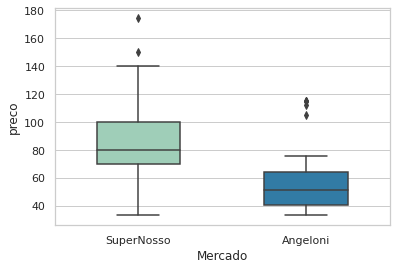

In [ ]:
sns.set_theme(style='whitegrid')
ax = sns.boxplot(x='Mercado', y='preco', data=dfMercado, 
                 width=0.5, palette='YlGnBu');